# Nsynth dataset

Reference: https://magenta.tensorflow.org/datasets/nsynth#format

### Parsing the JSON metafiles to a DataFrame

In [2]:
import pandas as pd
import numpy as np
import librosa
import os
import json
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Creating path variables
TRAIN_PATH = "./nsynth/nsynth-train" 
TEST_PATH = "./nsynth/nsynth-test" 
VALID_PATH = "./nsynth/nsynth-val" 

## Function Utils

In [4]:
# Exporting
def to_json(df, file_name='example.json'):
    df = df.set_index('file')
    df.index.name = None
    df.to_json(file_name, orient="index")

# Importing
def read_json(datapath):
    df = pd.read_json(datapath, orient='index')
    df['file'] = df.index
    df.reset_index(drop=True, inplace=True)
    return df

In [18]:
df_intru = df_train[df_train['instrument'] == 39]
print(df_intru['velocity'].unique())

[ 50 127  75 100  25]


In [3]:
df_train = read_json(os.path.join(TRAIN_PATH, "examples.json"))
df_train['stage'] = 'train'

df_test = read_json(os.path.join(TRAIN_PATH, "examples.json"))
df_test['stage'] = 'test'

df_valid = read_json(os.path.join(VALID_PATH, "examples.json"))
df_valid['stage'] = 'val'

print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

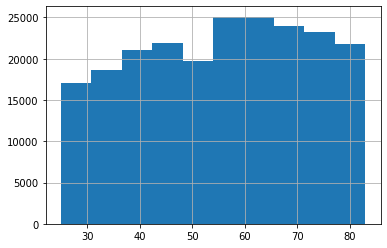

In [6]:
df_train = df_train[(df_train['pitch'] < 84)& ( df_train['pitch'] > 24)]
df_train['pitch'].hist()

Write file names into a separated txt file.

In [9]:
path = "./data/nsynth/train/audio/"
with open("training_files.txt", 'w') as f:
    for file in list(df_train['file']):
        f.write(path + file + ".wav" + "\n")

In [7]:
df = pd.concat([df_train ,df_test, df_valid])
assert len(df) == len(df_train) + len(df_test) + len(df_valid)

NameError: name 'df_train' is not defined

In [ ]:
df.to_csv("examples.csv", index=False)

# GANSynth

In [ ]:
df_train['instrument_family_str'].unique()

In [ ]:
instr = ['mallet','string','brass','reed', 'flute']
gan_synth_df = df_train[df_train['instrument_family_str'].isin(instr)]

In [35]:
len(gan_synth_df['instrument'].unique())

352

# Splitting trainset into a new validation and trainset partition 

The validation and test sets does not overlap with the same instruments in the training set, therefore we split the trainingset so that the new validation partition contains the same pitch and instruments labels.

In [52]:
new_eval_df = pd.DataFrame(columns=df_train.columns)
new_eval_df.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,file


In [53]:
instr_sample_size = 10
for instr_id in sorted(df_train['instrument'].unique()):
    sample_df = df_train[df_train['instrument'] == instr_id].sample(n=instr_sample_size, random_state=1)
    new_eval_df = pd.concat([new_eval_df, sample_df], axis=0)
print(new_eval_df.shape)

(9530, 14)


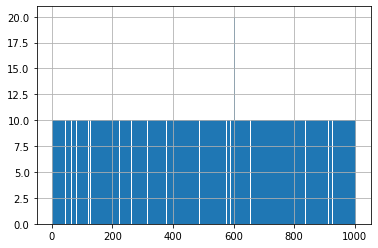

In [54]:
new_eval_df['instrument'].hist(bins=1000)

In [55]:
new_train_df = df_train.copy()

In [56]:
new_train_df = pd.concat([new_train_df, new_eval_df], axis = 0)
new_train_df.drop_duplicates(subset='file', keep=False, inplace=True)
print(new_train_df.shape)

(279675, 14)


In [57]:
to_json(new_train_df, "new_train_example.json")
to_json(new_eval_df, "new_eval_example.json")

In [58]:
# Loading json to DF
new_train_df = pd.read_json('new_train_example.json', orient='index')
new_train_df['file'] = new_train_df.index
new_train_df.reset_index(drop=True, inplace=True)

new_train_df.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,file
0,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",guitar_acoustic_001-082-050
1,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",bass_synthetic_120-108-050
2,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",organ_electronic_120-050-127
3,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",guitar_electronic_021-026-025
4,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",organ_electronic_011-079-075


In [40]:
# Filter instrument families and pitch
new_train_df = new_train_df[new_train_df['instrument_family_str'].isin(inst_list)]
new_train_df = new_train_df[(new_train_df['pitch'] < 84) & ( new_train_df['pitch'] > 24)]
print("New train df {}".format(new_train_df.shape))

new_eval_df = new_eval_df[new_eval_df['instrument_family_str'].isin(inst_list)]
new_eval_df = new_eval_df[(new_eval_df['pitch'] < 84) & ( new_eval_df['pitch'] > 24)]
print("New eval df: {}".format(new_eval_df.shape))

New train Df (66067, 14)
New eval Df: (2801, 14)


In [5]:
df_train = pd.read_json(os.path.join(TRAIN_PATH, "new_eval_example.json"), orient='index')
df_train['file'] = df_train.index
df_train.reset_index(drop=True, inplace=True)

print(df_train.shape)
df_train.drop_duplicates('file')
print(df_train.shape)

(9530, 14)
(9530, 14)


# New Data Split

In this training/validation we consider all data in train-valid-test datasets to expand the number of instrument families.

In [5]:
df = pd.concat([df_train,df_test,df_valid], axis=0)
print(df.shape)
df.head()

(305979, 15)


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,file,stage
0,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",guitar_acoustic_001-082-050,train
1,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",bass_synthetic_120-108-050,train
2,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",organ_electronic_120-050-127,train
3,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",guitar_electronic_021-026-025,train
4,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",organ_electronic_011-079-075,train


Creating an empty validation dataframe.

In [6]:
new_df_val = pd.DataFrame(columns=df.columns)
new_df_val.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,file,stage


In [23]:
grouped_df = df.groupby(['instrument_family_str', 'instrument_source_str']).size()
print(grouped_df)
print(grouped_df.shape)

instrument_family_str  instrument_source_str
bass                   acoustic                   200
                       electronic                8387
                       synthetic                60368
brass                  acoustic                 13760
                       electronic                  70
flute                  acoustic                  6572
                       electronic                  35
                       synthetic                 2816
guitar                 acoustic                 13343
                       electronic               16805
                       synthetic                 5275
keyboard               acoustic                  8508
                       electronic               42645
                       synthetic                 3838
mallet                 acoustic                 27722
                       electronic                5581
                       synthetic                 1763
organ                  acoustic      

Generating new column with new timbre class ids composed by instrument source and family.

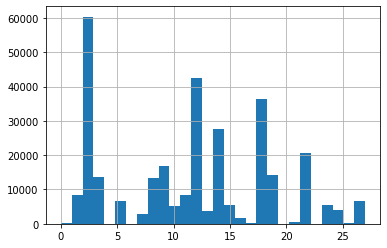

In [7]:
df['family_source_id'] = df['instrument_source']+ df['instrument_family'] * 3 # Generates ids for family source
family_source_id = sorted(df['family_source_id'].unique())
df['family_source_id'] = df['family_source_id'].apply(lambda x: family_source_id.index(x)) # Removing holes in ids

df['family_source_id'].hist(bins=28)

Filtering pitch data

59
(230018, 16)


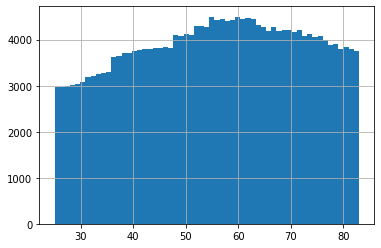

In [8]:
df = df[(df['pitch'] < 84) & ( df['pitch'] > 24)]
print(df['pitch'].nunique())
print(df.shape)
df['pitch'].hist(bins=59)

Filling validation set

In [9]:
new_df_train = df.copy()

# Filling validation df
for timbre_id in sorted(new_df_train['family_source_id'].unique()):
    sample_size = int(0.1*len(new_df_train[new_df_train['family_source_id'] == timbre_id])) # sampling is proportional to the sample size per class
    sample_df = new_df_train[new_df_train['family_source_id'] == timbre_id].sample(n=sample_size, random_state=1)
    new_df_val = pd.concat([new_df_val, sample_df], axis=0) 

# Removing duplicates between validation and training
new_df_train = pd.concat([new_df_train, new_df_val], axis = 0)
new_df_train.drop_duplicates(subset='file', keep=False, inplace=True)

print(new_df_train.shape)
print(new_df_val.shape)
print(df.shape)

(207030, 16)
(22988, 16)
(230018, 16)


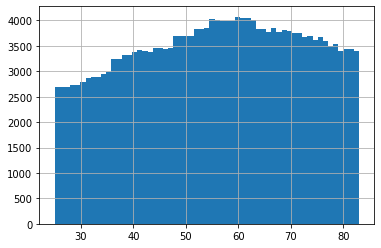

In [10]:
df_train['pitch'].hist(bins=59)

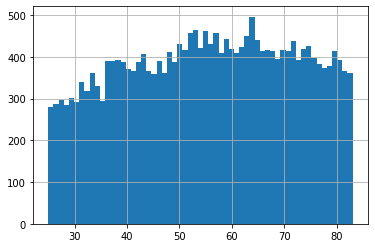

In [11]:
new_df_val['pitch'].hist(bins=59)

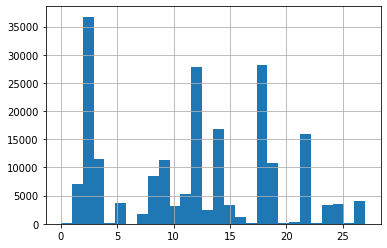

In [12]:
df_train['family_source_id'].hist(bins=28)

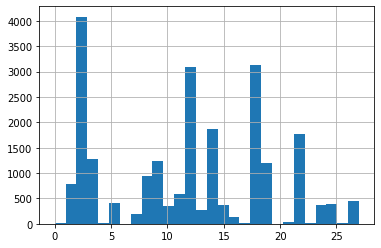

In [13]:
new_df_val['family_source_id'].hist(bins=28)

In [15]:
to_json(df, "all_dataset_family_source.json")
to_json(df_train, "train_family_source.json")
to_json(new_df_val, "val_family_source.json")

In [5]:
bla = read_json('./nsynth/all_dataset_family_source.json')
bla_train = read_json('./nsynth/train_family_source.json')
bla_val = read_json('./nsynth/val_family_source.json')

print(bla.shape)
print(bla_train.shape)
print(bla_val.shape)
bla.head()

(230018, 16)
(207030, 16)
(22988, 16)


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,stage,family_source_id,file
0,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",train,8,guitar_acoustic_001-082-050
1,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,18,organ_electronic_120-050-127
2,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",train,9,guitar_electronic_021-026-025
3,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,18,organ_electronic_011-079-075
4,282051,16000,44,1,keyboard,keyboard_electronic_089,keyboard_electronic_089-044-100,[],electronic,100,4,877,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,12,keyboard_electronic_089-044-100


In [20]:
bla[bla['instrument_str'] == 'brass_acoustic_003']

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,stage,family_source_id,file
71,69464,16000,75,0,brass,brass_acoustic_003,brass_acoustic_003-075-075,"[long_release, reverb]",acoustic,75,1,16,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-075-075
3434,34893,16000,73,0,brass,brass_acoustic_003,brass_acoustic_003-073-050,[reverb],acoustic,50,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-073-050
4135,5723,16000,68,0,brass,brass_acoustic_003,brass_acoustic_003-068-025,"[long_release, reverb]",acoustic,25,1,16,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-068-025
4261,87521,16000,69,0,brass,brass_acoustic_003,brass_acoustic_003-069-100,[reverb],acoustic,100,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-069-100
6682,89790,16000,73,0,brass,brass_acoustic_003,brass_acoustic_003-073-075,"[long_release, reverb]",acoustic,75,1,16,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-073-075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210184,72196,16000,74,0,brass,brass_acoustic_003,brass_acoustic_003-074-050,[reverb],acoustic,50,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-074-050
213283,79106,16000,68,0,brass,brass_acoustic_003,brass_acoustic_003-068-127,[reverb],acoustic,127,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-068-127
213670,72697,16000,59,0,brass,brass_acoustic_003,brass_acoustic_003-059-050,"[dark, long_release, reverb]",acoustic,50,1,16,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-059-050
214095,18276,16000,70,0,brass,brass_acoustic_003,brass_acoustic_003-070-100,"[long_release, reverb]",acoustic,100,1,16,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-070-100


In [22]:
bla[(bla['instrument_str'] == 'brass_acoustic_033')&(bla['pitch'] == 51)]

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,stage,family_source_id,file
277,34175,16000,51,0,brass,brass_acoustic_033,brass_acoustic_033-051-127,"[long_release, reverb]",acoustic,127,1,245,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_033-051-127
108517,40696,16000,51,0,brass,brass_acoustic_033,brass_acoustic_033-051-075,"[dark, long_release, reverb]",acoustic,75,1,245,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_033-051-075
176887,34123,16000,51,0,brass,brass_acoustic_033,brass_acoustic_033-051-025,"[dark, reverb]",acoustic,25,1,245,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_033-051-025
177329,77047,16000,51,0,brass,brass_acoustic_033,brass_acoustic_033-051-100,"[long_release, reverb]",acoustic,100,1,245,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_033-051-100
210578,6965,16000,51,0,brass,brass_acoustic_033,brass_acoustic_033-051-050,"[dark, reverb]",acoustic,50,1,245,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_033-051-050


In [6]:
bla[(bla['instrument_str'] == 'brass_acoustic_003')&(bla['pitch'] == 51)]

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,stage,family_source_id,file
9099,40227,16000,51,0,brass,brass_acoustic_003,brass_acoustic_003-051-025,"[dark, reverb]",acoustic,25,1,16,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-051-025
50361,67600,16000,51,0,brass,brass_acoustic_003,brass_acoustic_003-051-075,"[dark, long_release, reverb]",acoustic,75,1,16,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-051-075
60542,76168,16000,51,0,brass,brass_acoustic_003,brass_acoustic_003-051-100,"[dark, long_release, reverb]",acoustic,100,1,16,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-051-100
83108,67664,16000,51,0,brass,brass_acoustic_003,brass_acoustic_003-051-050,"[dark, reverb]",acoustic,50,1,16,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-051-050
134831,4437,16000,51,0,brass,brass_acoustic_003,brass_acoustic_003-051-127,"[long_release, reverb]",acoustic,127,1,16,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",train,3,brass_acoustic_003-051-127


(28000, 16)


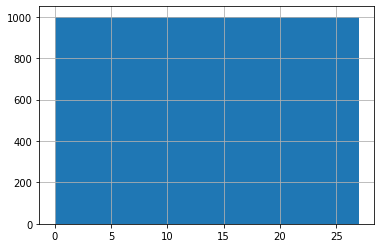

In [10]:
df_tmp = pd.DataFrame(columns=bla.columns)

# Filling df with random sampling, each class has the same number of samples.
for class_id in range(28):
    sampled_df = bla[bla['family_source_id'] == class_id].sample(
                                            1000, replace=True, random_state=1)
    df_tmp = pd.concat([df_tmp, sampled_df], axis = 0)

print(df_tmp.shape)
df_tmp['family_source_id'].hist(bins=28)